##  Kластеризация данных

In [100]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn import metrics
from sklearn.cluster import KMeans


from pickle import dump
# from yellowbrick.cluster import KElbowVisualizer
# from sklearn.mixture import GaussianMixture


sns.set(rc={'figure.figsize':(8,6)}, palette="muted")
# sns.set_style("whitegrid")

df = pd.read_table('./data/test_data.tsv')

df.head()

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash
0,347854231724,1050848,21,0,3818162082,8335634595980108828,2,2,1642713892,1732823002,17261330804588317013,16521739535555380904
1,329455126064,694606,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044
2,329455254926,694659,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044
3,329455273798,694596,36,0,3818162082,2563013194488493467,3,2,3529439892,673473971,8781226038565509786,14273372146021722044
4,329455293738,694608,36,0,3818162082,2563013194488493467,3,2,390304810,673473971,8781226038565509786,14273372146021722044


В данном отчете попробуем кластеризовать данные. Это должно помочь отделить обычных пользователей от ботов. Методика обработки данных:
    
    1. Вычисляем время, потребовавшееся на клик
    2. Выделяем в отдельный датасет пользователей, которые сделали клик
    3. Удаляем шум методом интерквартильного расстояния
    4. Применяем к данным стандартизацию (чтобы были больше похожи на нормальное распредление) и применяем MinMax преобразование

Среднее время, требующееся на клик: 789.2948128693369
Медианное время, требующееся на клик: 7.0
Удалено шумов 80


<ipython-input-101-7a36a306dd52>:22: RuntimeWarning: divide by zero encountered in log
  df_user_click['log_duration'] = np.log(df_user_click['duration'].values)
<ipython-input-101-7a36a306dd52>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_click['log_duration'] = np.log(df_user_click['duration'].values)


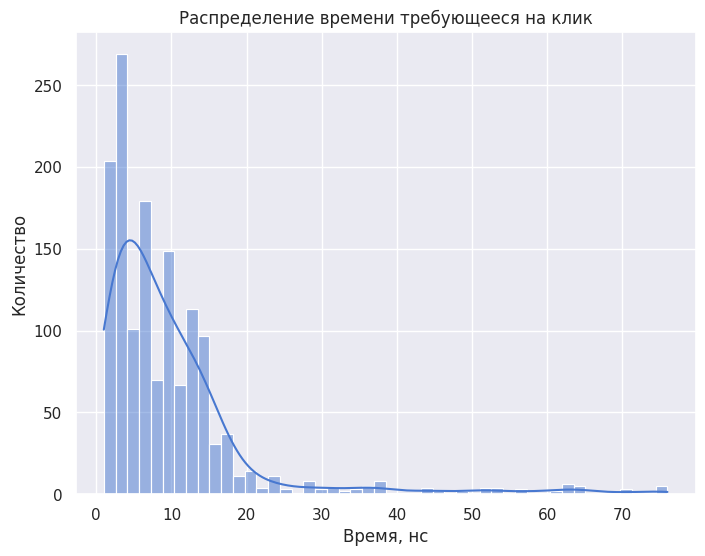

In [101]:
def tukey_noise(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]
    return df


df_sort = df.sort_values(by=['user', 't'], ascending=True, axis=0)
df_sort['duration'] = df_sort.groupby(by=['user'])['t'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]).values
df_sort['flg'] = df_sort.groupby(by=['user'])['tn'].rolling(window=2).apply(lambda x: 1 if x.iloc[1] == 1 and x.iloc[0] == 0 else 0).values
df_sort.fillna(value=0, inplace=True)

df_user_click = df_sort[df_sort['flg'] == 1]
mean_val = df_user_click['duration'].mean()
median_val = df_user_click['duration'].median()

print(f'Среднее время, требующееся на клик: {mean_val}\nМедианное время, требующееся на клик: {median_val}')

n_init = df_user_click.shape[0]

df_user_click['log_duration'] = np.log(df_user_click['duration'].values)
df_user_click = tukey_noise(df_user_click, 'log_duration')
n_temp = df_user_click.shape[0]
print(f'Удалено шумов {n_init - n_temp}')

figure = sns.histplot(data=df_user_click, x="duration", kde=True)
# figure = sns.histplot(data=df_user_click, x='duration')
plot_conf = figure.set(xlabel='Время, нс', ylabel='Количество',
                       title='Распределение времени требующееся на клик')

Применим два методо снижения размерности данных: `PCA` и `TSNE`. Подробную информацию об этих методах можно найти в разных источниках. Я лишь добавлю, что PCA как правильно находит только линейные комбинации признаков. Поэтому для сравнения воспользуемся еще более сложным методом как TSNE. Для кластеризации рассмотрим следующие столбцы: тип устройства, тип браузера, прологарифмируемое время на клик, хэш домена и id сайта

In [102]:
df_cluster = df_user_click[['devtype', 'brotype', 'log_duration', 'domhash', 'siteid']]

scaler = StandardScaler()
minmax = MinMaxScaler()

data_scaled = scaler.fit_transform(df_cluster)
data_scaled = pd.DataFrame(data=data_scaled, columns=df_cluster.columns, index=df_cluster.index)

data_scaled = minmax.fit_transform(data_scaled)
data_scaled = pd.DataFrame(data=data_scaled, columns=df_cluster.columns, index=df_cluster.index)

path_scaler = './models/scalers/standard_scaler.pkl'
path_minmax = './models/scalers/minmax_scaler.pkl'
dump(scaler, open(path_scaler, 'wb'))
dump(minmax, open(path_minmax, 'wb'))

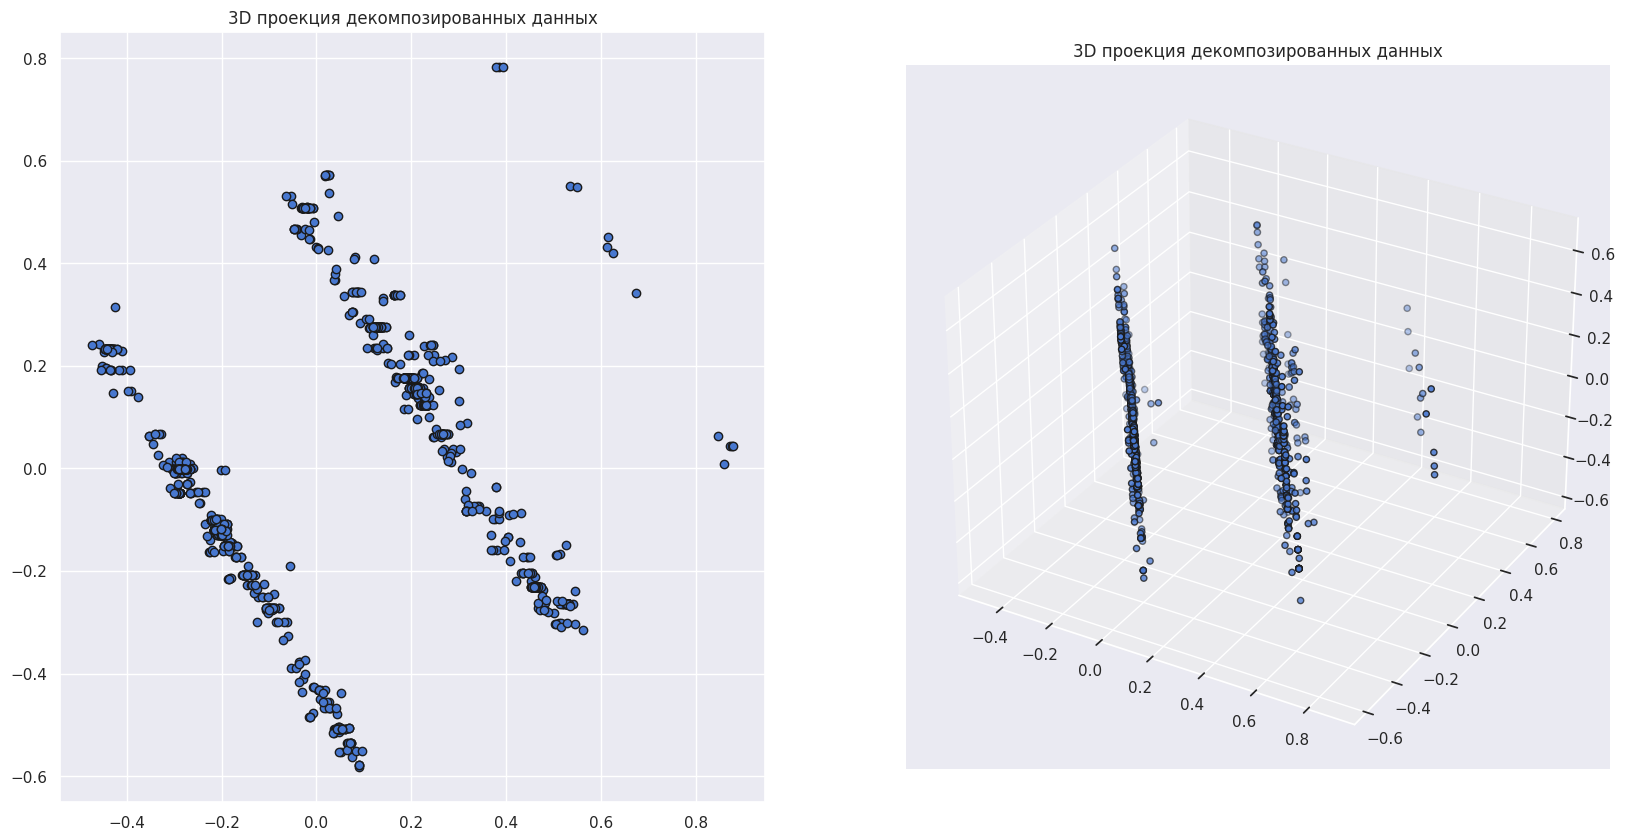

In [103]:
pca = decomposition.PCA(n_components=3)
X_pca_ratio_3d = pd.DataFrame(pca.fit_transform(data_scaled), columns=(["col1", "col2", "col3"]))

x = X_pca_ratio_3d["col1"]
y = X_pca_ratio_3d["col2"]
z = X_pca_ratio_3d["col3"]

#To plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(x,y,z, marker="o", edgecolors='k')
ax.set_title("3D проекция декомпозированных данных")

pca = decomposition.PCA(n_components=2)
X_pca_ratio_2d = pd.DataFrame(pca.fit_transform(data_scaled), columns=(["col1", "col2"]))
path_pca = './models/decomposition/pca.pkl'
dump(pca, open(path_pca, 'wb'))

x = X_pca_ratio_2d["col1"]
y = X_pca_ratio_2d["col2"]

ax = fig.add_subplot(1, 2, 1)
ax.scatter(x,y, marker="o", edgecolors='k')
ax.set_title("3D проекция декомпозированных данных")
plt.show()

`PCA` очень хорошо разбил пользователей на 3 группы. Можно предположить, что две группы это обычные пользователи и боты, а вторая  - оставшийся шум. Но пока вывод не будем делать. Посмотрим результат `TSNE`

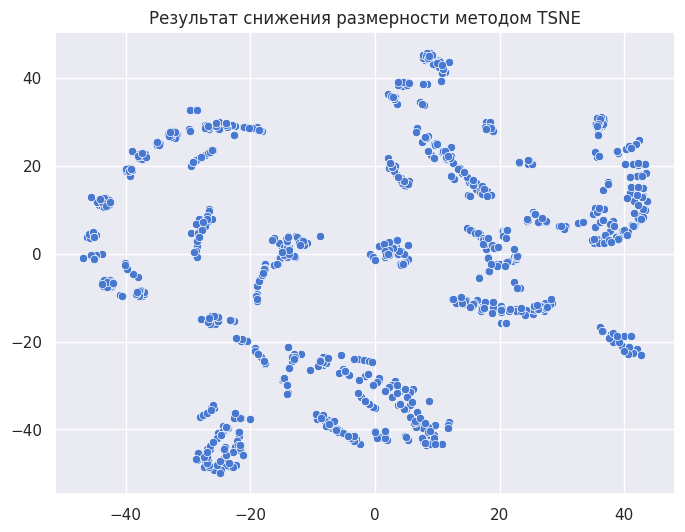

In [104]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(data_scaled)

figure = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], marker="o", edgecolors='k')
plot_conf = figure.set(title='Результат снижения размерности методом TSNE')

Результат `TSNE` оказался хуже. Для кластеризации будем использовать результат от `PCA`

Так как группы пользователей вытянуты в 3 плоскости, попробуем применить GMM.

In [110]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, random_state=0).fit(X_pca_ratio_2d.values)

df_cluster = X_pca_ratio_2d.copy()
df_cluster['gmm'] = gm.predict(X_pca_ratio_2d.values)
dump(gm, open(f'./models/clusters/gmm.pkl', 'wb'))

Кроме того, рассмотрим еще 5 методов кластеризации: KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering, DBSCAN. Для каждого метода посчитаем метрику Силуета и визуализируем результат.

In [111]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering, DBSCAN

epsilon = 0.08
min_samples = 10

algorithms = {'KMeans': KMeans(n_clusters=3, random_state=0),
              'AffinityPropagation': AffinityPropagation(),
              'SpectralClustering': SpectralClustering(n_clusters=3, random_state=0,
                                                       affinity='nearest_neighbors'),
              'AgglomerativeClustering': AgglomerativeClustering(n_clusters=3),
              'DBSCAN': DBSCAN(eps=epsilon, min_samples=min_samples)}

data = []
for algo in algorithms:
    algorithms[algo].fit(X_pca_ratio_2d.values)
    df_cluster[algo] = algorithms[algo].labels_
    dump(algorithms[algo], open(f'./models/clusters/{algo}.pkl', 'wb'))
    data.append(({'Silhouette': metrics.silhouette_score(X_pca_ratio_2d.values, df_cluster[algo])}))

results = pd.DataFrame(data=data, columns=[ 'Silhouette'],
                       index=list(algorithms.keys()))

results

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,Silhouette
KMeans,0.636234
AffinityPropagation,0.368678
SpectralClustering,0.020008
AgglomerativeClustering,0.636234
DBSCAN,0.559633


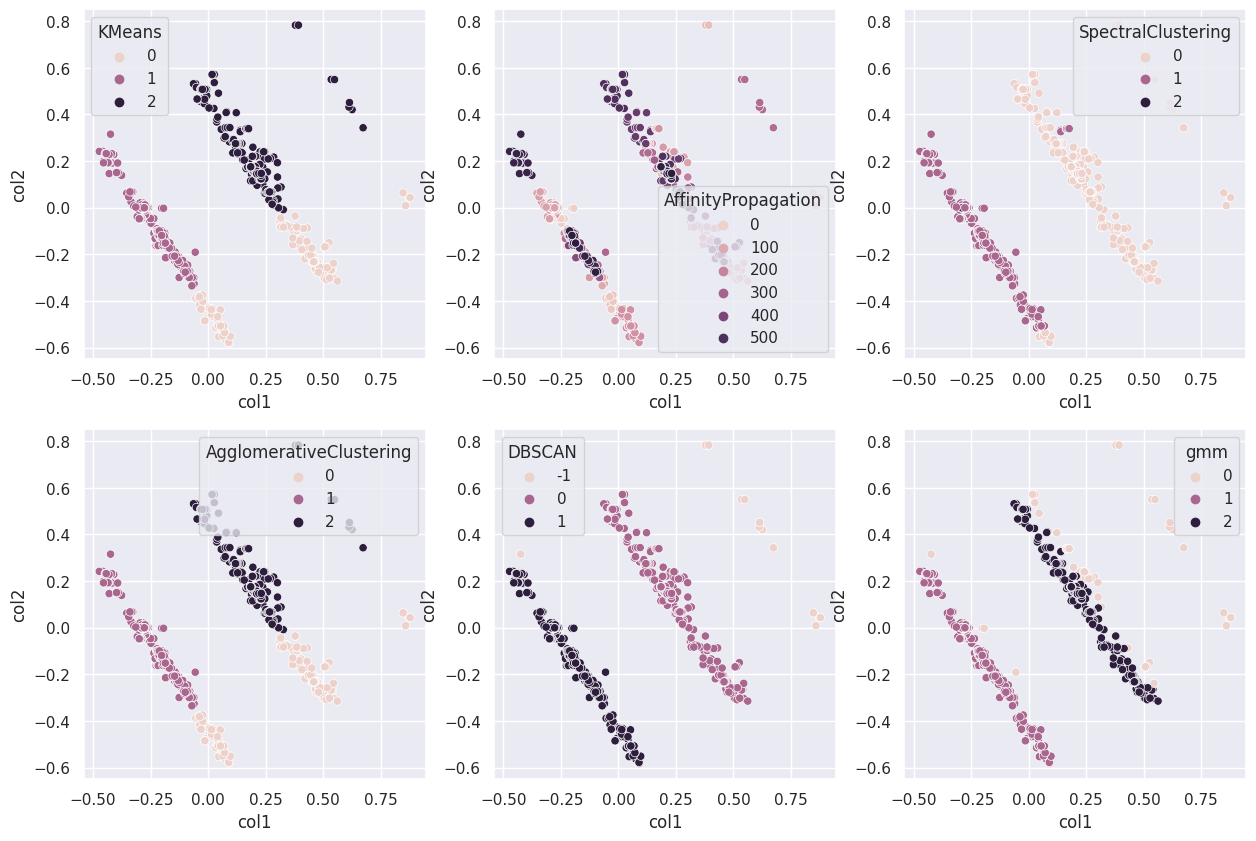

In [112]:
#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#create boxplot in each subplot
fig1 = sns.scatterplot(data=df_cluster, x='col1', y='col2', hue='KMeans', ax=axes[0,0])
fig2 = sns.scatterplot(data=df_cluster, x='col1', y='col2', hue='AffinityPropagation', ax=axes[0,1])
fig3 = sns.scatterplot(data=df_cluster, x='col1', y='col2', hue='SpectralClustering', ax=axes[0,2])
fig4 = sns.scatterplot(data=df_cluster, x='col1', y='col2', hue='AgglomerativeClustering', ax=axes[1,0])
fig5 = sns.scatterplot(data=df_cluster, x='col1', y='col2', hue='DBSCAN', ax=axes[1,1])
fig5 = sns.scatterplot(data=df_cluster, x='col1', y='col2', hue='gmm', ax=axes[1,2])

На мой взгляд, метод DBSCAN отлично справился с задачей. Помимо того, что он разделил на 2 группы, он еще определил оставшуюся часть как шум (результат согласуется с моим предположением). Попробуем кластеризовать всех пользователей и посмотреть чем же они отличаются.

In [115]:
# from pickle import load

# df_user_click = df_sort[df_sort['flg'] == 1]

# df_user_click['log_duration'] = np.log(df_user_click['duration'].values)

# df_cluster = df_user_click[['devtype', 'brotype', 'log_duration', 'domhash', 'siteid']]

# path_scaler = './models/scalers/standard_scaler.pkl'
# path_minmax = './models/scalers/minmax_scaler.pkl'


# scaler = load(open(path_scaler, 'rb'))
# minmax = load(open(path_minmax, 'rb'))

# df_cluster = df_cluster[np.isfinite(df_cluster).all(1)]

# data_scaled = scaler.transform(df_cluster)
# data_scaled = pd.DataFrame(data=data_scaled, columns=df_cluster.columns, index=df_cluster.index)

# data_scaled = minmax.transform(data_scaled)
# data_scaled = pd.DataFrame(data=data_scaled, columns=df_cluster.columns, index=df_cluster.index)

# path_pca = './models/decomposition/pca.pkl'
# path_model = './models/clusters/DBSCAN.pkl'

# pca = load(open(path_pca, 'rb'))
# X_pca_ratio_2d = pd.DataFrame(pca.transform(data_scaled), columns=(["col1", "col2"]))

# model = load(open(path_model, 'rb'))
# X_pca_ratio_2d['flg'] = model.predict(X_pca_ratio_2d.values)

# df_user_click['log_duration'] = X_pca_ratio_2d['flg']

# figure = sns.scatterplot(data=X_pca_ratio_2d, x='col1', y='col2', hue='flg')
# plot_conf = figure.set(title='Результат снижения размерности методом TSNE')